<h2>Bayesian treatment of the Olympic regression problem</h2>
<p>In this notebook, we will perform a Bayesian treatment of the Olympic regression problem. We start by loading the data and rescaling it to aid with numerics.</p>

In [1]:
import urllib
# urllib.urlretrieve('https://github.com/sdrogers/fcml/raw/master/notebooks/data/olympic100m.txt', 'olympic100m.txt')
import numpy as np
data = np.loadtxt('data100m.csv',delimiter=',')
x = data[:,0][:,None]
t = data[:,1][:,None]
x = x - x[0]
x = x/4.0

<p>And let's plot the data *again*</p>

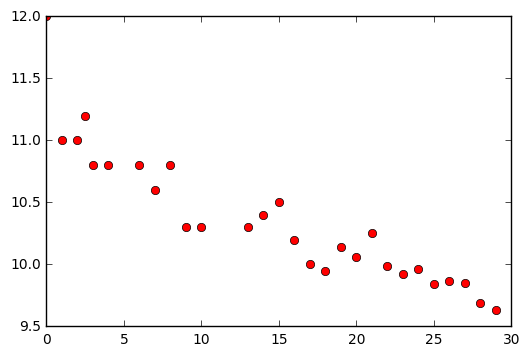

In [2]:
import pylab as plt
%matplotlib inline
plt.plot(x,t,'ro')

<p>We'll define a Gaussian prior over $\mathbf{w}$, with mean $\mathbf{0}$ and covariance $\left[\begin{array}{cc} 100& 0\\0 & 5\end{array}\right]$. We'll also fix $\sigma^2=2$.</p>

In [3]:
prior_mean = np.zeros((2,1))
prior_cov = np.array([[100,0],[0,5]])
sig_sq = 2

<p>Let's see what this prior means by sampling some $\mathbf{w}$ vectors from it and plotting the models</p>

(9, 12)

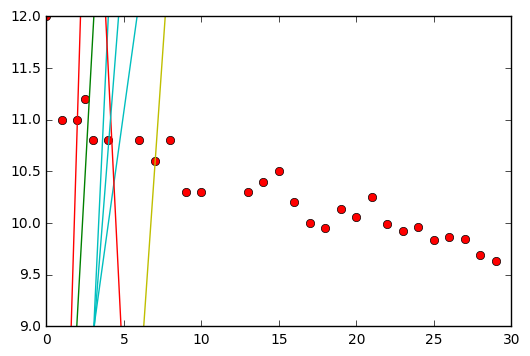

In [4]:
w_samp = np.random.multivariate_normal(prior_mean.flatten(),prior_cov,20)
plt.figure()
plt.plot(x,t,'ro')
plot_x = np.array([[1,0],[1,30]])
plt.plot([0,30],np.dot(w_samp,plot_x.T).T)
plt.ylim([9,12])

<p>we can also draw a contour plot of the prior:</p>

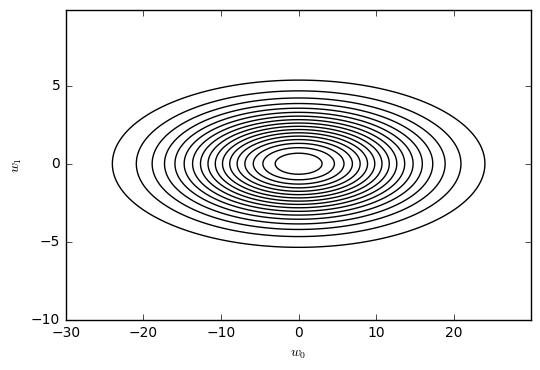

In [5]:
def gaussian2d(mu,sigma,xvals,yvals):
    const = (1.0/(2.0*np.pi))*(1.0/np.sqrt(np.linalg.det(sigma)))
    si = np.linalg.inv(sigma)
    xv = xvals-mu[0]
    yv = yvals-mu[1]
    return const * np.exp(-0.5*(xv*xv*si[0][0] + xv*yv*si[1][0] + yv*xv*si[0][1] + yv*yv*si[1][1]))


xp = np.arange(-30,30,0.1)
yp = np.arange(-10,10,0.1)
Xp,Yp = np.meshgrid(xp,yp)
Z = gaussian2d(prior_mean,prior_cov,Xp,Yp)
CS = plt.contour(Xp,Yp,Z,20,colors='k')
plt.xlabel('$w_0$')
plt.ylabel('$w_1$')

<p>We can now add the data - we'll do it two at a time to see how the posterior evolves. The left-hand plots show some samples from the posteior (blue lines) as well as the posterior mean (dark black line). The right hand plots show the prior contours (black) and the posterior contours (red). Note that we've zoomed into the area of interest.</p>

[[ 11.12293727]
 [ -0.05319782]] [[ 0.28106107 -0.01545975]
 [-0.01545975  0.00118833]]


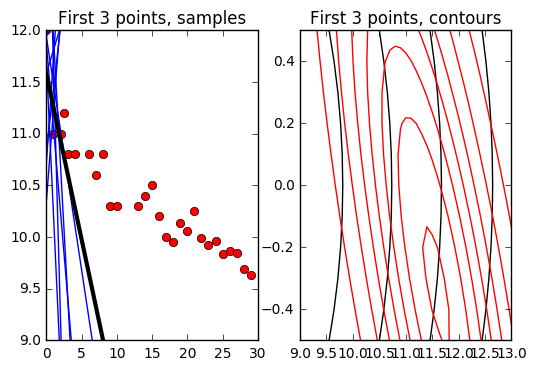

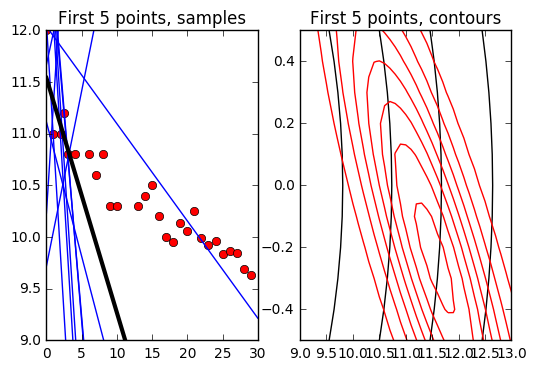

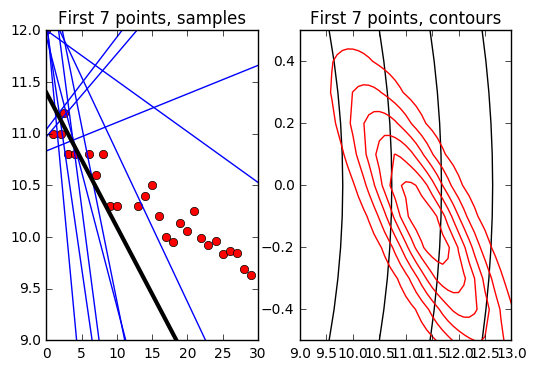

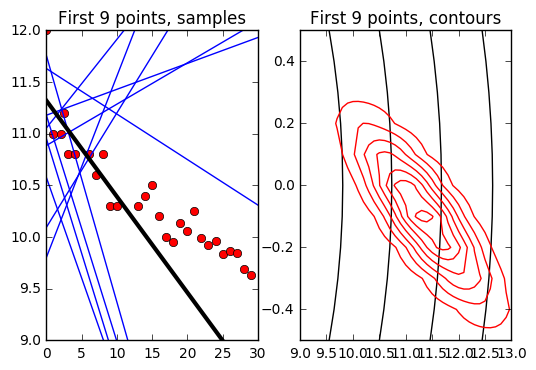

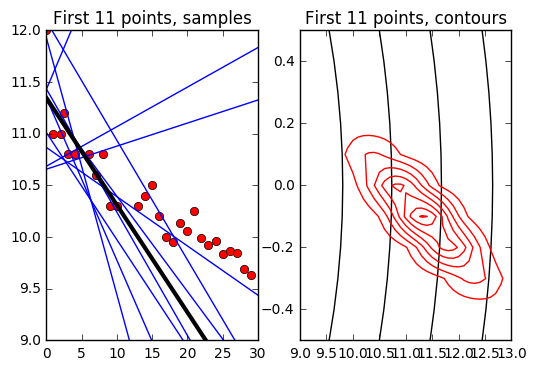

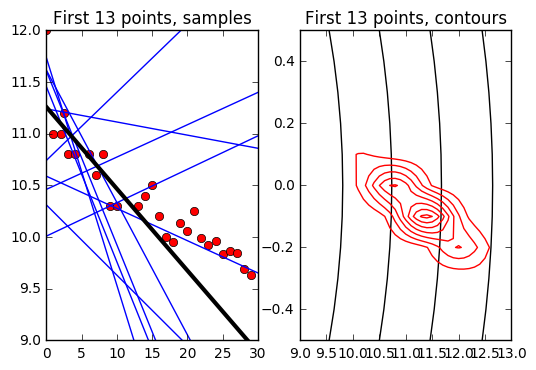

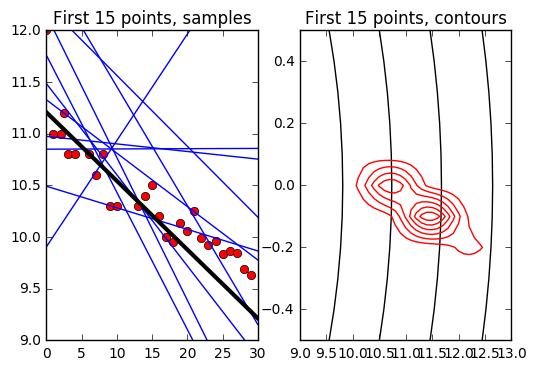

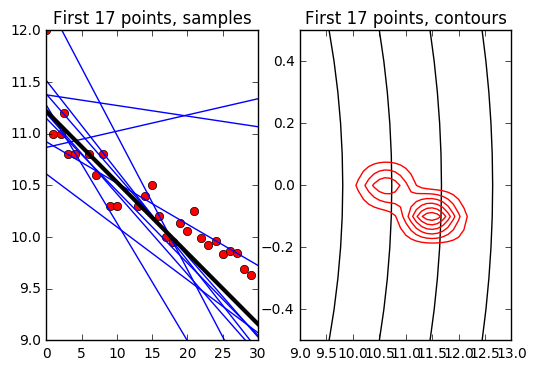

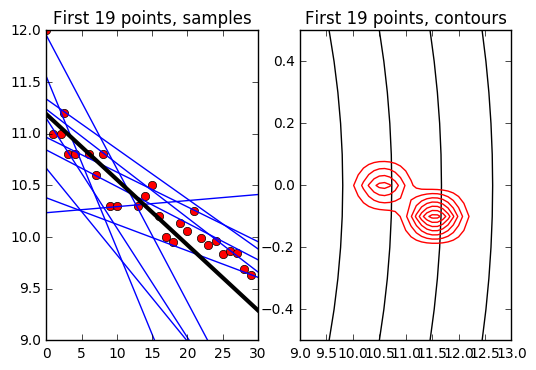

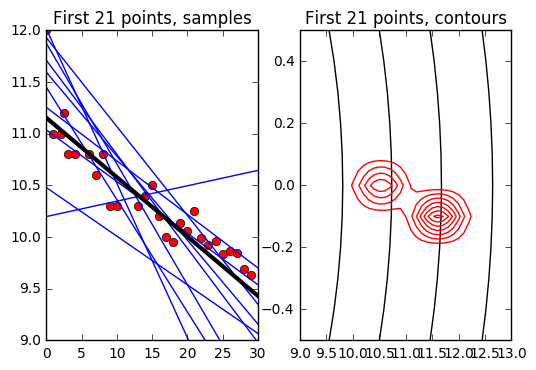

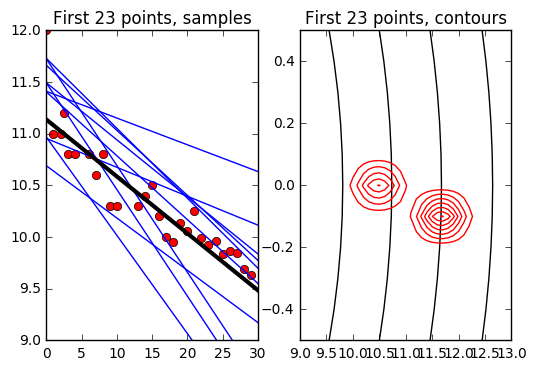

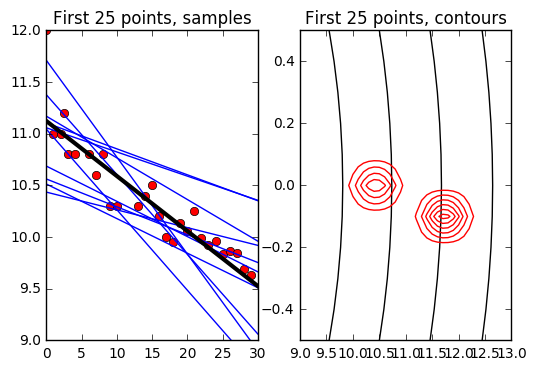

In [6]:
X = np.hstack((np.ones_like(x),x))
xpsub = np.arange(9,13,0.02)
ypsub = np.arange(-0.5,0.5,0.02)
Xpsub,Ypsub = np.meshgrid(xp,yp)
for i in np.arange(3,27,2):
    Xsub = X[0:i,:]
    tsub = t[0:i]
    siw = np.linalg.inv((1.0/sig_sq)*np.dot(Xsub.T,Xsub) + np.linalg.inv(prior_cov))
    muw = np.dot(siw,(1.0/sig_sq)*np.dot(Xsub.T,tsub) + np.dot(np.linalg.inv(prior_cov),prior_mean))
    plt.figure()
    plt.subplot(1,2,1)
    w_samp = np.random.multivariate_normal(muw.flatten(),siw,10)
    plt.plot(x,t,'ro')
    plt.plot([0,30],np.dot(w_samp,plot_x.T).T,'b')
    plt.plot([0,30],np.dot(plot_x,muw),'k',linewidth=3)
    plt.ylim([9,12])
    plt.title('First ' + str(i) + ' points, samples')
    plt.subplot(1,2,2)
    Zposterior = gaussian2d(muw,siw,Xpsub,Ypsub)
    CS = plt.contour(Xp,Yp,Z,20,colors='k')
    CS = plt.contour(Xpsub,Ypsub,Zposterior,colors='r')
    plt.xlim([9,13])
    plt.ylim([-0.5,0.5])
    plt.title('First ' + str(i) + ' points, contours')
    
print muw,siw

<p>We'll now look at predictions.</p>

In [10]:
max_order = 1
test_x = np.linspace(0,100,100)[:,None]
X = np.ones_like(x)
testX = np.ones_like(test_x)
for i in np.arange(max_order):
    X = np.hstack((X,x**(i+1)))
    testX = np.hstack((testX,test_x**(i+1)))
    
siw = np.linalg.inv((1.0/sig_sq)*np.dot(X.T,X) + np.linalg.inv(prior_cov))
muw = np.dot(siw,(1.0/sig_sq)*np.dot(X.T,t) + np.dot(np.linalg.inv(prior_cov),prior_mean))

predmean = np.dot(testX,muw)
predvar = sig_sq + np.diag(np.dot(testX,np.dot((siw),testX.T)))

<Container object of 3 artists>

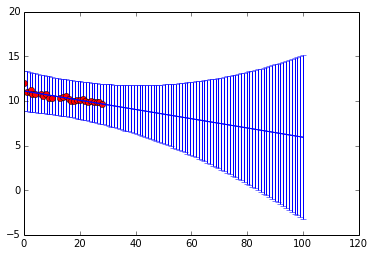

In [38]:
plt.plot(x,t,'ro')
plt.plot(test_x,predmean,'b')
plt.errorbar(test_x.flatten(),predmean.flatten(),yerr=predvar.flatten())